In [136]:
!pip install pandas numpy matplotlib scipy

In [137]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

N = 14
TARGET_COLUMN = "Daily_Usage_Hours"
DATASET_PATH  = "../datasets/teen_phone_addiction_dataset.csv"

BINS = 12

### Подсчёт характеристик

Среднее 5.020666666666667
Дисперсия 3.827895520729132
Мода 0    4.4
Name: Daily_Usage_Hours, dtype: float64
Медиана 5.0
Квантили 0.25: 3.7, 0.5: 5.0, 0.75: 6.4
Эксцесс -0.12081610863833259
Ассиметрия 0.016205396823206885
Интерквартильный размах 2.7


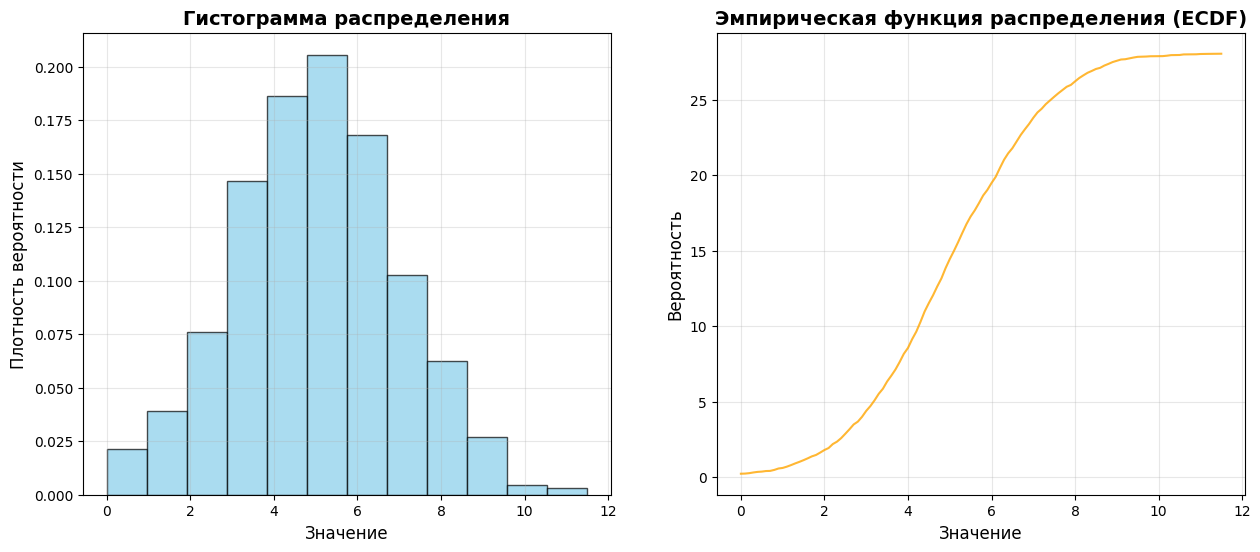

In [138]:
data = pd.read_csv(DATASET_PATH)[TARGET_COLUMN]

def show_stats(data):
    print(f"Среднее {data.mean()}")
    print(f"Дисперсия {data.var()}")
    print(f"Мода {data.mode()}")
    print(f"Медиана {data.median()}")
    print(f"Квантили {", ".join([f"{coef}: {data.quantile(coef)}" for coef in [.25, .5, .75]])}")
    print(f"Эксцесс {data.kurtosis()}")
    print(f"Ассиметрия {data.skew()}")
    print(f"Интерквартильный размах {data.quantile(.75) - data.quantile(.25)}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.hist(data, bins=BINS, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    ax1.set_title('Гистограмма распределения', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Значение', fontsize=12)
    ax1.set_ylabel('Плотность вероятности', fontsize=12)
    ax1.grid(alpha=0.3)

    from collections import Counter
    items = [*Counter(data).items()]
    items.sort()

    x, y = zip(*items)

    y = list(y)

    for i in range(1, len(y)):
        y[i] += y[i - 1]
    y = np.array(y) / len(y)

    ax2.plot(x, y, color='orange', alpha=0.8)
    ax2.set_title('Эмпирическая функция распределения (ECDF)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Значение', fontsize=12)
    ax2.set_ylabel('Вероятность', fontsize=12)
    ax2.grid(alpha=0.3)

show_stats(data)

### Проверки на нормальность

Критерий $\chi^2$

In [139]:
def check_hi2(data):
    n = len(data)
    from collections import Counter
    items = [*Counter(data).items()]
    items.sort()

    x, y = zip(*items)
    mean = data.mean()
    sigma = np.std(data, ddof=1)

    hist, bin_edges = np.histogram(data, bins=BINS, density=False)

    expected_freq = []
    for i in range(len(bin_edges) - 1):
        prob = (stats.norm.cdf(bin_edges[i+1], mean, sigma) - 
                stats.norm.cdf(bin_edges[i], mean, sigma))
        expected_freq.append(prob * n)
    expected_freq = np.array(expected_freq)
    valid_indices = expected_freq >= 1

    expected = expected_freq[valid_indices]
    observed = hist[valid_indices]

    chi2_stat = np.sum((observed - expected) ** 2 / expected)

    df = max(1, len(observed) - 3)

    return 1 - stats.chi2.cdf(chi2_stat, df) 


check_hi2(data)

np.float64(0.0058286673883078954)

Ассиметрия и эксцесс близки к 0, что говорит о схожести распределения данных с нормальным.

### Q-Q График

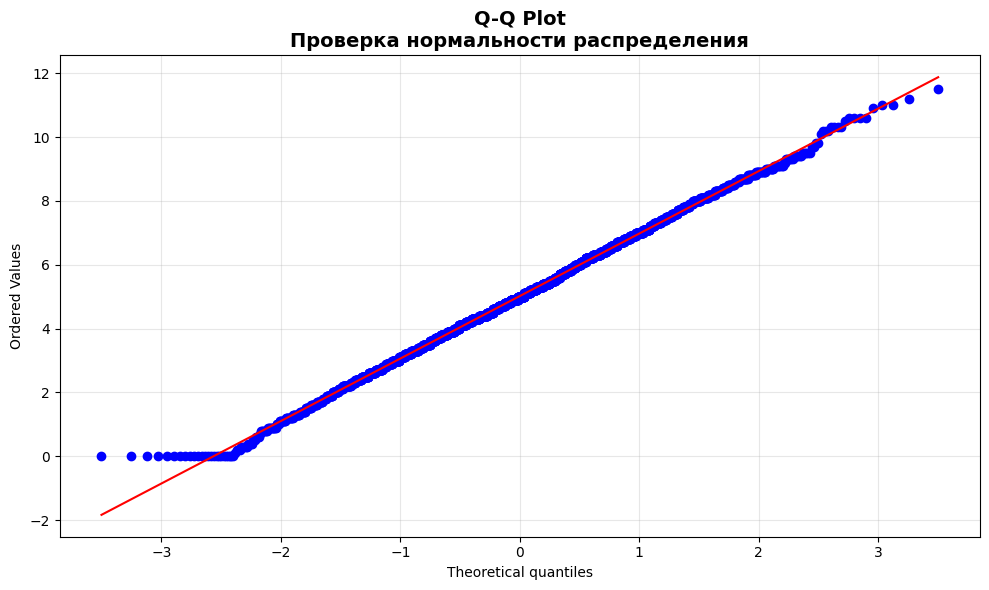

In [140]:
def qq_plot(data, title="Q-Q Plot"):
    plt.figure(figsize=(10, 6))
    
    # Строим Q-Q plot
    stats.probplot(data, dist="norm", plot=plt)
    
    plt.title(f'{title}\nПроверка нормальности распределения', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
qq_plot(data)

### Группировка по School_Grade

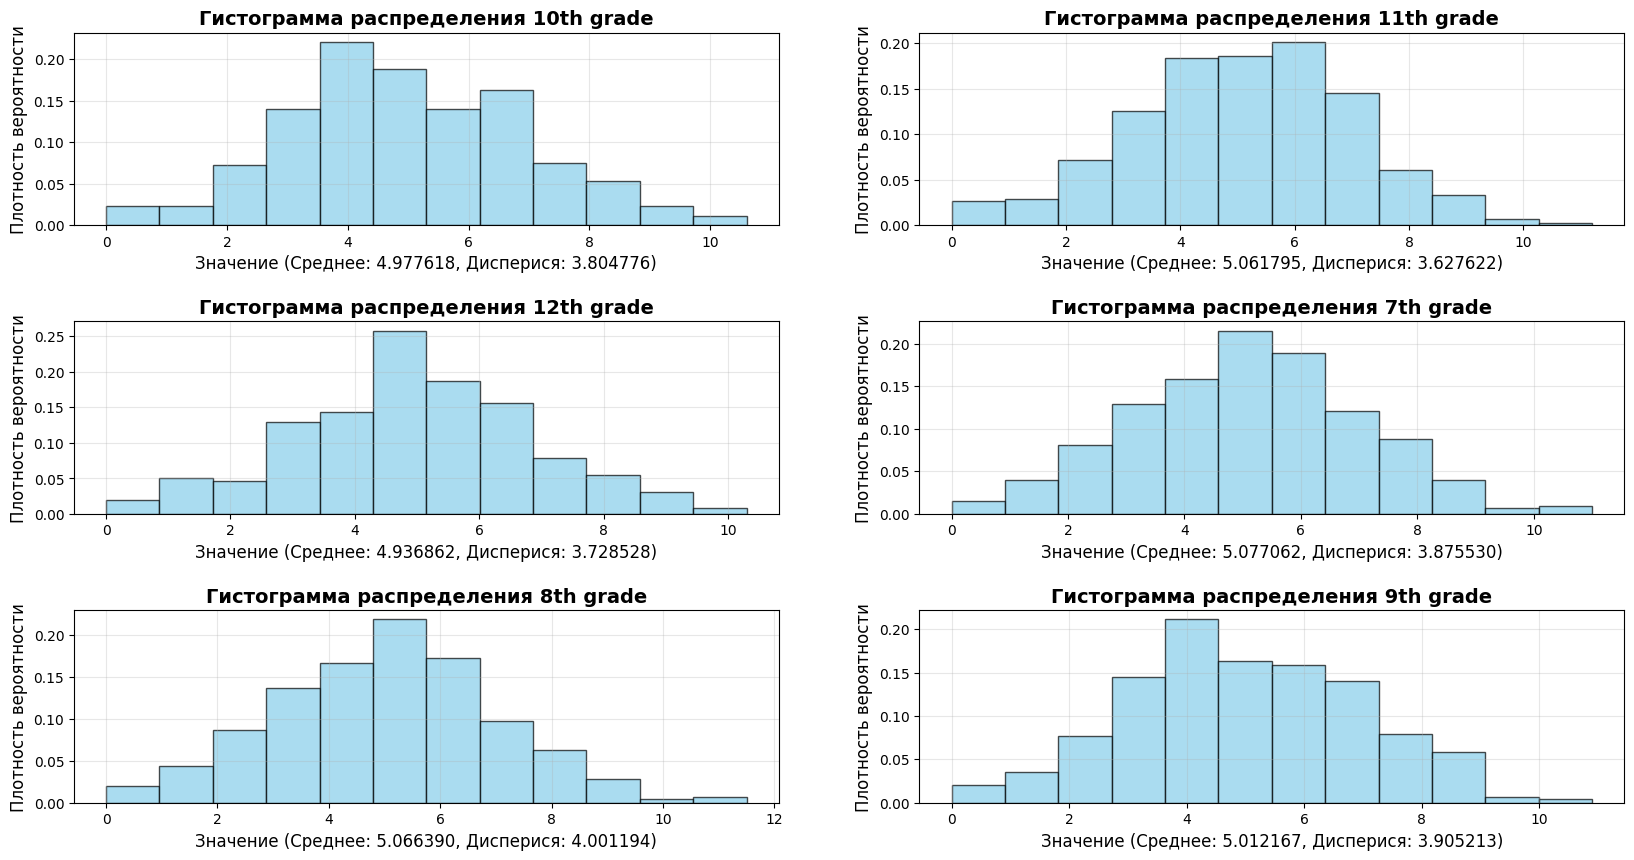

In [141]:
groups = pd.read_csv(DATASET_PATH).groupby("School_Grade")[TARGET_COLUMN].apply(list).to_dict()

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10), )
plt.subplots_adjust(hspace=0.5)

for ind, (grade, data) in enumerate(groups.items()):
    i, j = (ind // ncols, ind % ncols)
    axes[i][j].hist(data, bins=BINS, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    axes[i][j].set_title(f'Гистограмма распределения {grade} grade', fontsize=14, fontweight='bold')
    axes[i][j].set_xlabel(f'Значение (Среднее: {np.mean(data):3f}, Дисперися: {np.var(data):3f})', fontsize=12)
    axes[i][j].set_ylabel('Плотность вероятности', fontsize=12)
    axes[i][j].grid(alpha=0.3)

Можно видеть, что данные из разных грейдов распределенны очень схожим образом. Следовательно, можно сделать вывод, что люди разного возраста пользуются телефоном одинаковое количество времени.